# Determining x and Q<sup>2</sup> from the scattered electron

In this notebook we determine DIS kinematics parameters from the scattered lepton side. For more details, see the page on the [BNL wiki](https://wiki.bnl.gov/eic/index.php/DIS_Kinematics). The following image gives the summary:
<img src="https://wiki.bnl.gov/eic/upload/Dis.variables.png" width="50%"/>

## Importing packages

Depending on the versions of uproot and XRootD that you have installed, you may encouter a warning from uproot below. Nevertheless, because of the simple data format of the ATHENA ROOT files, we are able to ignore this warning.

In [1]:
import numpy as np
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt

/srv/conda/envs/notebook/lib/python3.7/site-packages/uproot/reading.py:186: FutureWarning: XRootD 5.1.1 is not fully supported; either upgrade to 5.2.0+ or set

    open.defaults["xrootd_handler"] = uproot.MultithreadedXRootDSource

  warnings.warn(message, FutureWarning)


## Opening a file with uproot

To test uproot, we will open a sample file (a DIS simulation sample):

In [2]:
server = 'root://sci-xrootd.jlab.org//osgpool/eic/'
file = 'ATHENA/RECO/master/DIS/NC/18x275/minQ2=10/pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.0001.root'

In [3]:
events = ur.open(server + file + ':events')

## Accessing the reconstructed particle momentum

We will access the particle momentum in the `ReconstructedParticles` branch. This contains the reconstructed momentum from the tracking system. As a reminder, here are the available fields:

In [4]:
events['ReconstructedParticles'].keys()

['ReconstructedParticles.ID.value',
 'ReconstructedParticles.p.x',
 'ReconstructedParticles.p.y',
 'ReconstructedParticles.p.z',
 'ReconstructedParticles.v.x',
 'ReconstructedParticles.v.y',
 'ReconstructedParticles.v.z',
 'ReconstructedParticles.time',
 'ReconstructedParticles.pid',
 'ReconstructedParticles.status',
 'ReconstructedParticles.charge',
 'ReconstructedParticles.momentum',
 'ReconstructedParticles.energy',
 'ReconstructedParticles.mass',
 'ReconstructedParticles.weight.value']

For this analysis we will only use the three-momentum `p` and the particle identication code `pid`. We will select only electrons (`pid == 11`) and combine them with their initial momentum $\vec{p}_0$ which, in the ATHENA coordinate system, is in the negative $z$ direction by definition.

In [5]:
reconstructed_particles = events['ReconstructedParticles'].arrays()

In [6]:
kp1, kp2, kp3 = reconstructed_particles['ReconstructedParticles.p.x'], reconstructed_particles['ReconstructedParticles.p.y'], reconstructed_particles['ReconstructedParticles.p.z']
pid = reconstructed_particles['ReconstructedParticles.pid']
m = reconstructed_particles['ReconstructedParticles.mass']

The mass of the particle is stored, but completely defined by the `pid` code. For the electron it is indeed always 0.511 MeV.

In [7]:
m[pid==11]

<Array [[0.000511], [0.000511], ... [], []] type='12502 * var * float32'>

## Determining the momentum transfer $Q^2$

For all particles we can calculate the energy, which we will consider the zeroth component of the four-momentum $p$.

In [8]:
kp0 = np.sqrt(m**2+(kp1**2+kp2**2+kp3**2))

The four-momentum of the incoming electron beam has only a $p_z$ and $E$ component.

In [9]:
k3 = -18
m0 = 0.000511
k0 = np.sqrt(m0**2 + k3**2)

We can now calculate the components of the four-momentum transfer $q_\mu = (k_\mu - k'_\mu)$:

In [10]:
q0 = k0 - kp0
q1 =    - kp1
q2 =    - kp2
q3 = k3 - kp3

With the four components we can form the squared four-momentum transfer, a scalar quantity, which is $Q^2 = -q^2$:

In [11]:
Q2 = -(q0**2 - q1**2 - q2**2 - q3**2)

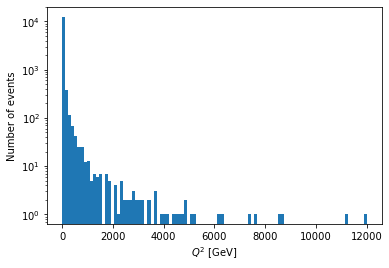

In [12]:
plt.hist(ak.flatten(Q2[pid==11]), bins=100)
plt.yscale('log')
plt.xlabel('$Q^2$ [GeV]')
plt.ylabel('Number of events')
plt.show()

As we can see, the $Q^2$ falls rapidly in this sample: large $Q^2$ events are less well represented than small $Q^2$ samples. Let's verify that the lower limit is indeed 1 GeV<sup>2</sup>.

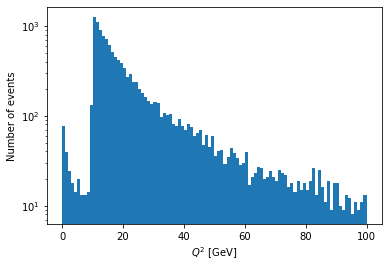

In [14]:
plt.hist(ak.flatten(Q2[pid==11]), range=[0,100], bins=100)
plt.yscale('log')
plt.xlabel('$Q^2$ [GeV]')
plt.ylabel('Number of events')
plt.show()

We can see that a very small number of entries fall below 10 GeV<sup>2</sup>. This is because we have not made any attempt at ensuring that only 1 electron track per event is taken into account. An extension of this exercise could involve selecting only the largest momentum electron in those cases where there are multiple electrons in an event.

## Determining the momentum fraction $x$

In order to determine $x$ we also need the incoming proton momentum $\vec{p}$. While it might be appealing to think that the proton momentum must be exactly along the $z$ axis as well, this is not the case in the interaction points of the EIC. At interaction point 6 (IP6), the crossing angle is -25 mrad in the $xz$ plane. Thus, the proton four-momentum is:

In [15]:
alpha = -0.025
p1 = 275 * np.sin(alpha)
p2 = 0
p3 = 275 * np.cos(alpha)
p0 = np.sqrt(0.938**2 + p1**2 + p2**2 + p3**2)

With this proton four-momentum we can now calculate the product $p \cdot q$, another scalar quantity:

In [16]:
pq = p0 * q0 - p1 * q1 - p2 * q2 - p3 * q3

and finally also $x = \frac{Q^2}{2 pq}$:

In [17]:
x = 0.5 * Q2 / pq

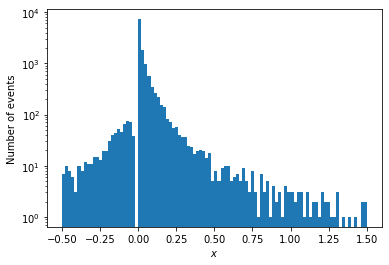

In [23]:
plt.hist(ak.flatten(x[pid==11]), range=[-0.5, 1.5], bins=100)
plt.yscale('log')
plt.xlabel('$x$')
plt.ylabel('Number of events')
plt.show()

Without a limit on the allowable values of $x$, between 0 and 1 for electron-proton scattering, we are once again easily fooled by outlier events that are caused by non-primary electrons in the event. We can limit our range and choose a logarithmic $x$-axis:

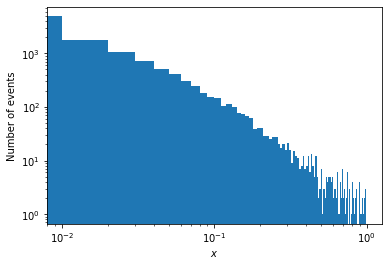

In [24]:
plt.hist(ak.to_numpy(x[Q2==ak.max(Q2[pid==11],1)]), range=[0,1], bins=100)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x$')
plt.ylabel('Number of events')
plt.show()

We are still not entirely happy witht his figure, so we change to logarithmic binning as well:

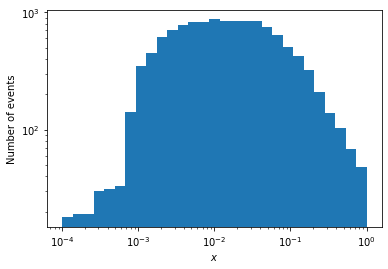

In [28]:
x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
plt.hist(ak.flatten(x[pid==11]), bins=x_bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x$')
plt.ylabel('Number of events')
plt.show()

## Kinematic coverage plot for DIS events

Finally, let's put our work on $Q^2$ and $x$ together to calculate a characteristic plot in DIS: the coverage in the $Q^2$ vs $x$ plane.

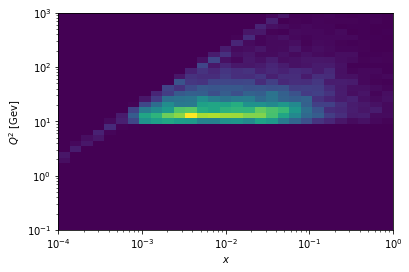

In [29]:
x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(-1, 3, 40) # specify exponents of 10
plt.hist2d(ak.to_numpy(ak.flatten(x[pid==11])), ak.to_numpy(ak.flatten(Q2[pid==11])), bins = [x_bins, Q2_bins])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x$')
plt.ylabel('$Q^2$ [Gev]')
plt.show()

## Next steps

There are several next steps you can take from here.
- You could compare the kinematic coverage for several different beam energy configurations (this requires more than just a change in the file you load).
- You could attempt to load multiple files, to increase the statistical precision of your sample.